In [22]:
import pandas as pd 
crop_data = pd.read_csv('crop_recommendation.csv')
fertilizer_data = pd.read_csv('fertilizer_recommendation.csv')
crop_data_head = crop_data.head()
fertilizer_data_head = fertilizer_data.head()
crop_missing = crop_data.isnull().sum()
fertilizer_missing = fertilizer_data.isnull().sum()
crop_data_head, fertilizer_data_head, crop_missing, fertilizer_missing
fertilizer_data['Soil Type'].unique()

array(['Clayey', 'Loamy', 'Red', 'Black', 'Sandy'], dtype=object)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Preprocessing for the crop dataset
crop_features = crop_data.drop(columns=['label'])
crop_labels = crop_data['label']

# Normalize continuous features for the crop dataset
scaler_crop = StandardScaler()
crop_features_scaled = scaler_crop.fit_transform(crop_features)

# Encode the target column (crop labels)
encoder_crop = LabelEncoder()
crop_labels_encoded = encoder_crop.fit_transform(crop_labels)

# Train-test split for the crop dataset
crop_X_train, crop_X_test, crop_y_train, crop_y_test = train_test_split(
    crop_features_scaled, crop_labels_encoded, test_size=0.2, random_state=42
)

# Preprocessing for the fertilizer dataset
fertilizer_features = fertilizer_data.drop(columns=['Fertilizer Name'])
fertilizer_labels = fertilizer_data['Fertilizer Name']

# Normalize continuous columns for fertilizer dataset
scaler_fertilizer = StandardScaler()
fertilizer_features[fertilizer_features.columns[:6]] = scaler_fertilizer.fit_transform(fertilizer_features[fertilizer_features.columns[:6]])
# Define all possible categories for Soil Type and Crop Type upfront
soil_type_categories = fertilizer_data['Soil Type'].unique()
crop_type_categories = fertilizer_data['Crop Type'].unique()

# Encode categorical columns consistently
soil_type_encoder = LabelEncoder()
soil_type_encoder.fit(soil_type_categories)
fertilizer_features['Soil Type'] = soil_type_encoder.transform(fertilizer_features['Soil Type'])

crop_type_encoder = LabelEncoder()
crop_type_encoder.fit(crop_type_categories)
fertilizer_features['Crop Type'] = crop_type_encoder.transform(fertilizer_features['Crop Type'])

# Encode target column (fertilizer labels)
fertilizer_label_encoder = LabelEncoder()
fertilizer_labels_encoded = fertilizer_label_encoder.fit_transform(fertilizer_labels)

# Train-test split for the fertilizer dataset
fertilizer_X_train, fertilizer_X_test, fertilizer_y_train, fertilizer_y_test = train_test_split(
    fertilizer_features, fertilizer_labels_encoded, test_size=0.2, random_state=42
)

# Outputs to confirm preprocessing is complete
crop_X_train.shape, crop_X_test.shape, fertilizer_X_train.shape, fertilizer_X_test.shape


((1760, 7), (440, 7), (441, 8), (111, 8))

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
import numpy as np

crop_model = Sequential([
    Input(shape=(crop_X_train.shape[1],)),  # Input layer, matching the number of features in crop dataset
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(crop_y_train)), activation='softmax')  # Output layer: number of unique crop types
])

crop_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
crop_history=crop_model.fit(crop_X_train, crop_y_train, epochs=20, batch_size=32, validation_data=(crop_X_test, crop_y_test))

# Evaluate Crop Model
crop_loss, crop_acc = crop_model.evaluate(crop_X_test, crop_y_test)
print(f"Crop Prediction Accuracy: {crop_acc}")




fertilizer_model = Sequential([
    Input(shape=(fertilizer_X_train.shape[1],)),  # Input size based on fertilizer features
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(fertilizer_y_train)), activation='softmax')  # Output layer: number of fertilizer types
])

# Compile the model
fertilizer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the fertilizer recommendation model
fertilizer_history=fertilizer_model.fit(fertilizer_X_train, fertilizer_y_train, epochs=20, batch_size=32, validation_data=(fertilizer_X_test, fertilizer_y_test))

# Evaluate the model on the test data
fertilizer_loss, fertilizer_acc = fertilizer_model.evaluate(fertilizer_X_test, fertilizer_y_test)
print(f"Fertilizer Recommendation Accuracy: {fertilizer_acc}")


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1595 - loss: 2.9564 - val_accuracy: 0.5295 - val_loss: 2.2742
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6465 - loss: 1.9681 - val_accuracy: 0.7750 - val_loss: 1.2616
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8157 - loss: 1.0403 - val_accuracy: 0.8455 - val_loss: 0.6953
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9174 - loss: 0.5621 - val_accuracy: 0.9000 - val_loss: 0.4623
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9328 - loss: 0.3750 - val_accuracy: 0.9250 - val_loss: 0.3477
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9408 - loss: 0.2903 - val_accuracy: 0.9386 - val_loss: 0.2865
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9496 - loss: 0.2311 - val_accuracy: 0.9364 - val_loss: 0.2428
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9611 - loss: 0.1905 - val_accuracy: 0.9477 - val_loss:

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Traditional ML Models for Crop Prediction ---
rf_crop_model = RandomForestClassifier(random_state=42)
rf_crop_model.fit(crop_X_train, crop_y_train)
rf_crop_predictions = rf_crop_model.predict(crop_X_test)

# Metrics for Crop Prediction
rf_crop_acc = accuracy_score(crop_y_test, rf_crop_predictions)
rf_crop_precision = precision_score(crop_y_test, rf_crop_predictions, average='weighted')
rf_crop_recall = recall_score(crop_y_test, rf_crop_predictions, average='weighted')
rf_crop_f1 = f1_score(crop_y_test, rf_crop_predictions, average='weighted')

print(f"Random Forest Crop Prediction Accuracy: {rf_crop_acc}")

# --- Traditional ML Models for Fertilizer Recommendation ---
rf_fertilizer_model = RandomForestClassifier(random_state=42)
rf_fertilizer_model.fit(fertilizer_X_train, fertilizer_y_train)
rf_fertilizer_predictions = rf_fertilizer_model.predict(fertilizer_X_test)

# Metrics for Fertilizer Recommendation
rf_fertilizer_acc = accuracy_score(fertilizer_y_test, rf_fertilizer_predictions)
rf_fertilizer_precision = precision_score(fertilizer_y_test, rf_fertilizer_predictions, average='weighted')
rf_fertilizer_recall = recall_score(fertilizer_y_test, rf_fertilizer_predictions, average='weighted')
rf_fertilizer_f1 = f1_score(fertilizer_y_test, rf_fertilizer_predictions, average='weighted')

print(f"Random Forest Fertilizer Recommendation Accuracy: {rf_fertilizer_acc}")

# --- Comparison Table ---
import pandas as pd
comparison_table = pd.DataFrame({
    "Model": ["Deep Learning (Crop)", "Random Forest (Crop)", "Deep Learning (Fertilizer)", "Random Forest (Fertilizer)"],
    "Accuracy": [crop_acc, rf_crop_acc, fertilizer_acc, rf_fertilizer_acc],
    "Precision": ["-", rf_crop_precision, "-", rf_fertilizer_precision],
    "Recall": ["-", rf_crop_recall, "-", rf_fertilizer_recall],
    "F1 Score": ["-", rf_crop_f1, "-", rf_fertilizer_f1],
})
print(comparison_table)


Random Forest Crop Prediction Accuracy: 0.9931818181818182
Random Forest Fertilizer Recommendation Accuracy: 1.0
                        Model  Accuracy Precision    Recall  F1 Score
0        Deep Learning (Crop)  0.952273         -         -         -
1        Random Forest (Crop)  0.993182  0.993735  0.993182  0.993175
2  Deep Learning (Fertilizer)  0.936937         -         -         -
3  Random Forest (Fertilizer)  1.000000       1.0       1.0       1.0


In [44]:
# Get Random Forest predictions as features
rf_crop_features_train = rf_crop_model.predict_proba(crop_X_train)
rf_crop_features_test = rf_crop_model.predict_proba(crop_X_test)

# Add them to the original feature set
cascade_crop_train = np.hstack((crop_X_train, rf_crop_features_train))
cascade_crop_test = np.hstack((crop_X_test, rf_crop_features_test))

# Train a new Deep Learning model with extended features
cascade_crop_model = Sequential([
    Input(shape=(cascade_crop_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(crop_y_train)), activation='softmax')
])

cascade_crop_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cascade_crop_history=cascade_crop_model.fit(cascade_crop_train, crop_y_train, epochs=20, batch_size=32, validation_data=(cascade_crop_test, crop_y_test))

# Evaluate
cascade_crop_loss, cascade_crop_acc = cascade_crop_model.evaluate(cascade_crop_test, crop_y_test)
print(f"Cascade Model Crop Prediction Accuracy: {cascade_crop_acc}")


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2416 - loss: 2.8691 - val_accuracy: 0.6614 - val_loss: 1.9921
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7826 - loss: 1.6003 - val_accuracy: 0.9386 - val_loss: 0.7920
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9809 - loss: 0.5794 - val_accuracy: 0.9818 - val_loss: 0.2817
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.1847 - val_accuracy: 0.9864 - val_loss: 0.1376
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0835 - val_accuracy: 0.9909 - val_loss: 0.0877
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0451 - val_accuracy: 0.9932 - val_loss: 0.0673
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0276 - val_accuracy: 0.9932 - val_loss: 0.0540
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0191 - val_accuracy: 0.9932 - val_loss:

In [39]:
# Get Random Forest predictions as features
rf_fertilizer_features_train = rf_fertilizer_model.predict_proba(fertilizer_X_train)
rf_fertilizer_features_test = rf_fertilizer_model.predict_proba(fertilizer_X_test)

# Add them to the original fertilizer features
cascade_fertilizer_train = np.hstack((fertilizer_X_train, rf_fertilizer_features_train))
cascade_fertilizer_test = np.hstack((fertilizer_X_test, rf_fertilizer_features_test))

# Train a new Deep Learning model with extended features
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

cascade_fertilizer_model = Sequential([
    Input(shape=(cascade_fertilizer_train.shape[1],)),  # Updated input size
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(fertilizer_y_train)), activation='softmax')  # Output size matches the number of fertilizer types
])

# Compile the model
cascade_fertilizer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cascade_fertilizer_history=cascade_fertilizer_model.fit(
    cascade_fertilizer_train, fertilizer_y_train,
    epochs=20, batch_size=32,
    validation_data=(cascade_fertilizer_test, fertilizer_y_test)
)

# Evaluate the model on the test data
cascade_fertilizer_loss, cascade_fertilizer_acc = cascade_fertilizer_model.evaluate(cascade_fertilizer_test, fertilizer_y_test)
print(f"Cascade Model Fertilizer Recommendation Accuracy: {cascade_fertilizer_acc}")


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0975 - loss: 3.0322 - val_accuracy: 0.2072 - val_loss: 2.4745
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2634 - loss: 2.3623 - val_accuracy: 0.2523 - val_loss: 2.2717
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3600 - loss: 2.1348 - val_accuracy: 0.3874 - val_loss: 2.0511
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4791 - loss: 1.9941 - val_accuracy: 0.4685 - val_loss: 1.8075
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5336 - loss: 1.7594 - val_accuracy: 0.5045 - val_loss: 1.5705
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5376 - loss: 1.5424 - val_accuracy: 0.6757 - val_loss: 1.3361
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6860 - loss: 1.2936 - val_accuracy: 0.7748 - val_loss: 1.0886
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7415 - loss: 1.0160 - val_accuracy: 0.8649 - val_loss

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict with Random Forest on the test set
rf_crop_probs_test = rf_crop_model.predict_proba(crop_X_test)

# Combine RF probabilities with scaled features
cascade_crop_test = np.hstack((crop_X_test, rf_crop_probs_test))

# Predict with the Deep Learning model
dl_crop_predictions = cascade_crop_model.predict(cascade_crop_test)
cascade_crop_predictions = np.argmax(dl_crop_predictions, axis=1)

# Calculate Metrics
accuracy_crop = accuracy_score(crop_y_test, cascade_crop_predictions)
precision_crop = precision_score(crop_y_test, cascade_crop_predictions, average='weighted')
recall_crop = recall_score(crop_y_test, cascade_crop_predictions, average='weighted')
f1_crop = f1_score(crop_y_test, cascade_crop_predictions, average='weighted')
confusion_crop = confusion_matrix(crop_y_test, cascade_crop_predictions)

# Print Metrics
print(f"Cascading Model (Crop Prediction) Metrics:")
print(f"Accuracy: {accuracy_crop}")
print(f"Precision: {precision_crop}")
print(f"Recall: {recall_crop}")
print(f"F1 Score: {f1_crop}")
print(f"Confusion Matrix:\n{confusion_crop}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Cascading Model (Crop Prediction) Metrics:
Accuracy: 0.990909090909091
Precision: 0.9915703463203464
Recall: 0.990909090909091
F1 Score: 0.9909052180784402
Confusion Matrix:
[[23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  

In [13]:
# Predict with Random Forest on the test set
rf_fertilizer_probs_test = rf_fertilizer_model.predict_proba(fertilizer_X_test)

# Combine RF probabilities with scaled features
cascade_fertilizer_test = np.hstack((fertilizer_X_test, rf_fertilizer_probs_test))

# Predict with the Deep Learning model
dl_fertilizer_predictions = cascade_fertilizer_model.predict(cascade_fertilizer_test)
cascade_fertilizer_predictions = np.argmax(dl_fertilizer_predictions, axis=1)

# Calculate Metrics
accuracy_fertilizer = accuracy_score(fertilizer_y_test, cascade_fertilizer_predictions)
precision_fertilizer = precision_score(fertilizer_y_test, cascade_fertilizer_predictions, average='weighted')
recall_fertilizer = recall_score(fertilizer_y_test, cascade_fertilizer_predictions, average='weighted')
f1_fertilizer = f1_score(fertilizer_y_test, cascade_fertilizer_predictions, average='weighted')
confusion_fertilizer = confusion_matrix(fertilizer_y_test, cascade_fertilizer_predictions)

# Print Metrics
print(f"Cascading Model (Fertilizer Recommendation) Metrics:")
print(f"Accuracy: {accuracy_fertilizer}")
print(f"Precision: {precision_fertilizer}")
print(f"Recall: {recall_fertilizer}")
print(f"F1 Score: {f1_fertilizer}")
print(f"Confusion Matrix:\n{confusion_fertilizer}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Cascading Model (Fertilizer Recommendation) Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[ 5  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 26  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 24]]


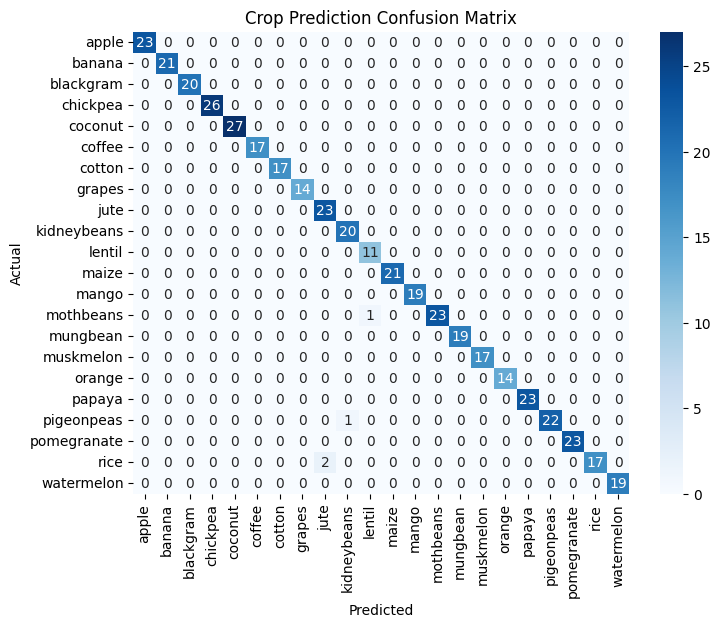

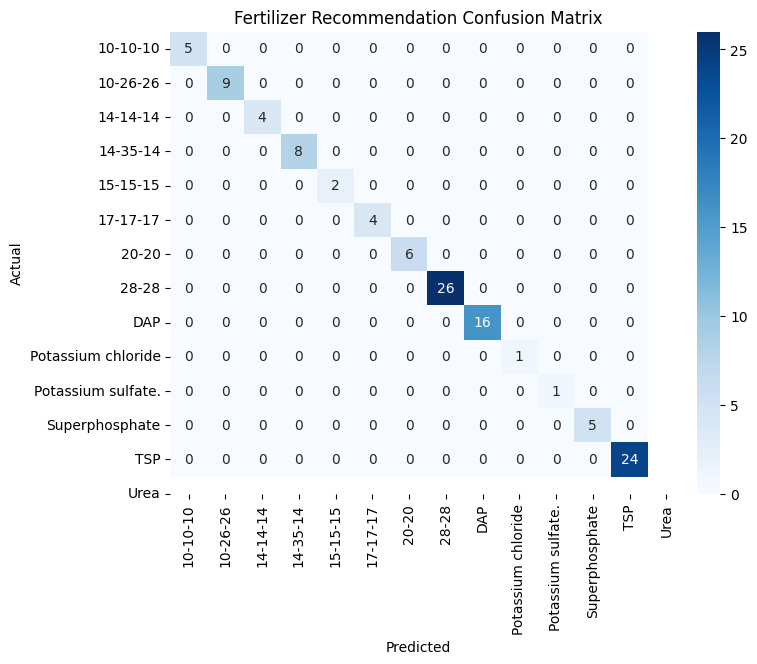

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot for Crop Prediction
crop_labels = encoder_crop.classes_
plot_confusion_matrix(confusion_crop, crop_labels, "Crop Prediction Confusion Matrix")

# Plot for Fertilizer Recommendation
fertilizer_labels = fertilizer_label_encoder.classes_
plot_confusion_matrix(confusion_fertilizer, fertilizer_labels, "Fertilizer Recommendation Confusion Matrix")


In [15]:
import pandas as pd

metrics_summary = pd.DataFrame({
    "Model": ["Crop Prediction", "Fertilizer Recommendation"],
    "Accuracy": [accuracy_crop, accuracy_fertilizer],
    "Precision": [precision_crop, precision_fertilizer],
    "Recall": [recall_crop, recall_fertilizer],
    "F1 Score": [f1_crop, f1_fertilizer]
})

print(metrics_summary)


                       Model  Accuracy  Precision    Recall  F1 Score
0            Crop Prediction  0.990909    0.99157  0.990909  0.990905
1  Fertilizer Recommendation  1.000000    1.00000  1.000000  1.000000


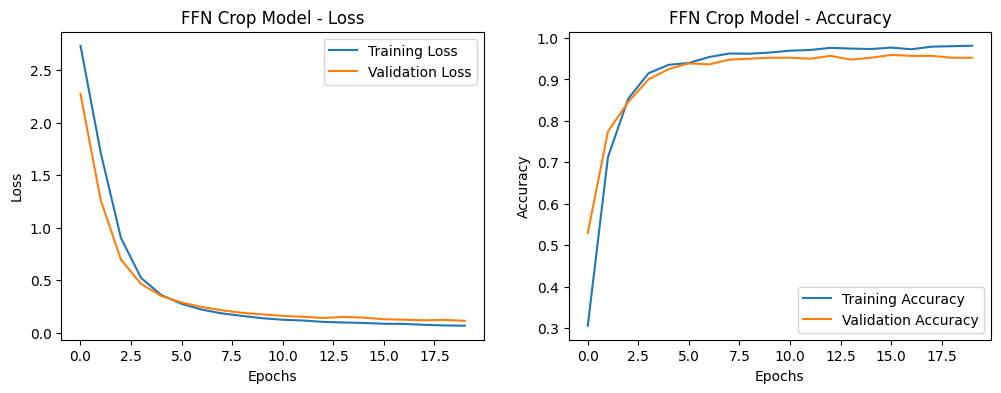

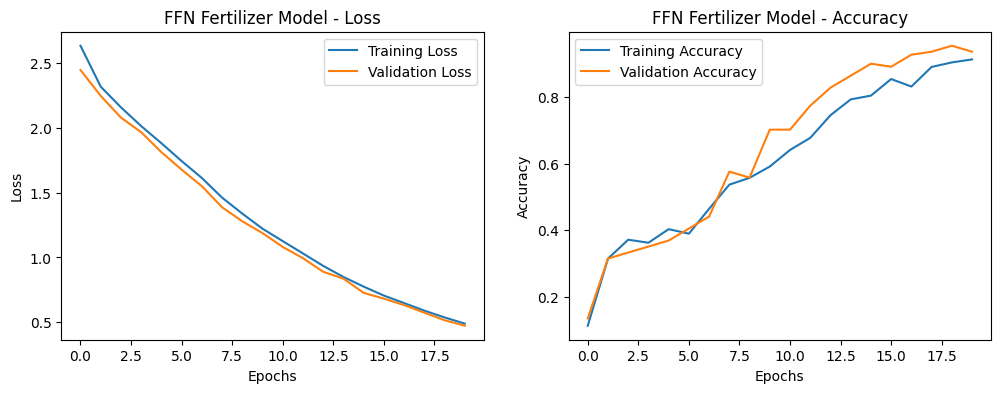

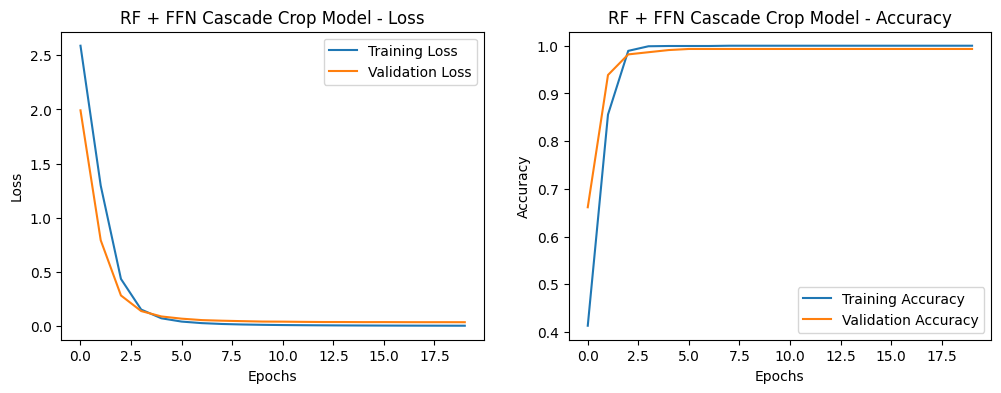

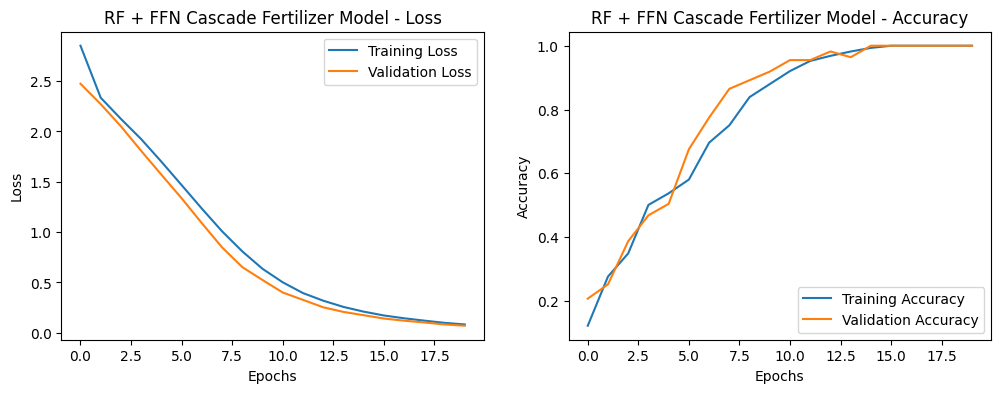

In [46]:
import matplotlib.pyplot as plt

# Function to plot metrics from history
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plot metrics for each model
plot_history(crop_history, "FFN Crop Model")
plot_history(fertilizer_history, "FFN Fertilizer Model")
plot_history(cascade_crop_history, "RF + FFN Cascade Crop Model")
plot_history(cascade_fertilizer_history, "RF + FFN Cascade Fertilizer Model")


In [9]:
# Save Crop Prediction Model
cascade_crop_model.save('crop_model.keras')

# Save Fertilizer Recommendation Model
cascade_fertilizer_model.save('fertilizer_model.keras')


In [10]:
import joblib
joblib.dump(rf_crop_model,'rf_crop_model.pkl')
joblib.dump(rf_fertilizer_model,'rf_fertilizer_model.pkl')
# Save scalers
joblib.dump(scaler_crop, 'scaler_crop.pkl')
joblib.dump(scaler_fertilizer, 'scaler_fertilizer.pkl')

# Save encoders
joblib.dump(encoder_crop, 'encoder_crop.pkl')
joblib.dump(soil_type_encoder, 'soil_type_encoder.pkl')
joblib.dump(crop_type_encoder, 'crop_type_encoder.pkl')
joblib.dump(fertilizer_label_encoder, 'fertilizer_label_encoder.pkl')


['fertilizer_label_encoder.pkl']